<a href="https://colab.research.google.com/github/MargotHuet/Ampelos/blob/master/Ampelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_folder = '/content/drive/MyDrive/Ampelos/data/train'

In [27]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30


**LOADING DATA**



In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5774 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']

**DATA VIZ - AFFICHER QUELQUES DONNEES DE CHAQUE CLASS**

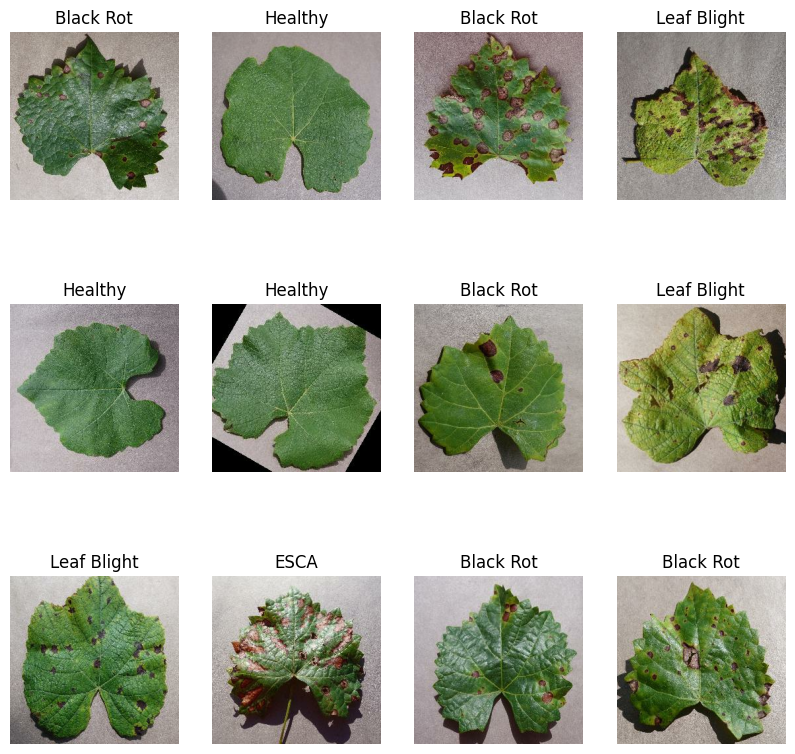

In [6]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

**TRAIN TEST SPLIT**

In [7]:
len(dataset)

181

In [8]:
train_size = 0.8
len(dataset) * train_size

144.8

In [9]:
train_ds = dataset.take(144)
len(train_ds)

144

In [10]:
test_ds = dataset.skip(144)
len(test_ds)

37

In [11]:
val_size = 0.1
len(dataset) * val_size

18.1

In [12]:
val_ds = test_ds.take(18)
len(val_ds)

18

In [13]:
test_ds = test_ds.skip(18)
len(test_ds)

19

**DATA AUGMENTATION**

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):

  ds_size = len(ds)

  if shuffle :
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_size * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).take(val_size)


  return train_ds, test_ds, val_ds

In [15]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

144
19
18


**Optimisation des données d'entrainement pour accelerer le processus d'apprentissage et améliorer les perf du modèle.**

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

**BUILD AND TRAIN CNN MODEL
 (convolutional neural network)**

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes= 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation=r'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation=r'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
144/144 [==============================] - 624s 4s/step - loss: 0.0449 - accuracy: 0.9852 - val_loss: 0.3150 - val_accuracy: 0.9149
Epoch 2/30
144/144 [==============================] - 611s 4s/step - loss: 0.0716 - accuracy: 0.9759 - val_loss: 0.1277 - val_accuracy: 0.9653
Epoch 3/30
144/144 [==============================] - 606s 4s/step - loss: 0.0548 - accuracy: 0.9807 - val_loss: 0.1032 - val_accuracy: 0.9653
Epoch 4/30
144/144 [==============================] - 617s 4s/step - loss: 0.0515 - accuracy: 0.9829 - val_loss: 0.1581 - val_accuracy: 0.9497
Epoch 5/30
144/144 [==============================] - 596s 4s/step - loss: 0.0413 - accuracy: 0.9846 - val_loss: 0.1067 - val_accuracy: 0.9705
Epoch 6/30
144/144 [==============================] - 612s 4s/step - loss: 0.0659 - accuracy: 0.9776 - val_loss: 0.0827 - val_accuracy: 0.9809
Epoch 7/30
144/144 [==============================] - 615s 4s/step - loss: 0.0731 - accuracy: 0.9744 - val_loss: 0.1162 - val_accuracy: 0.9635

In [29]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 36s 2s/step - loss: 0.0126 - accuracy: 0.9949


In [30]:
scores

[0.012648980133235455, 0.994915246963501]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']

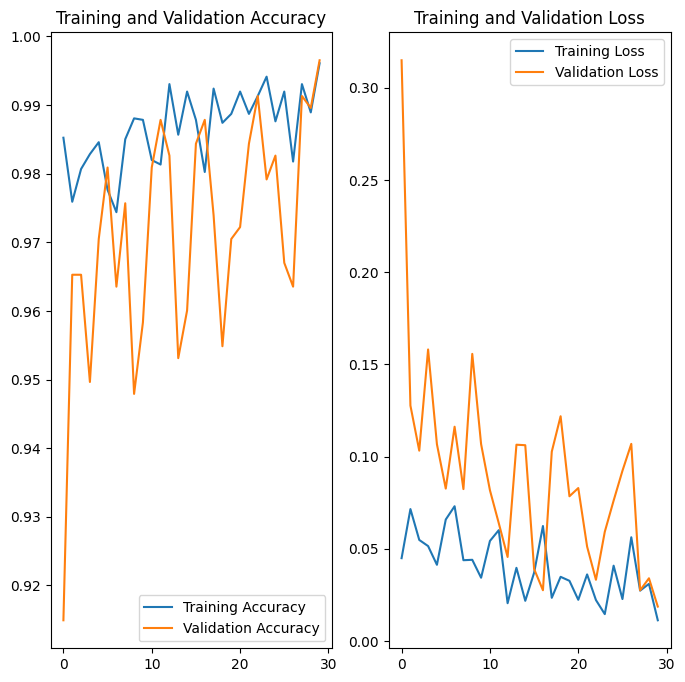

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label:  Leaf Blight
1/1 [==============================] - 1s 1s/step
Predicted label:  Leaf Blight


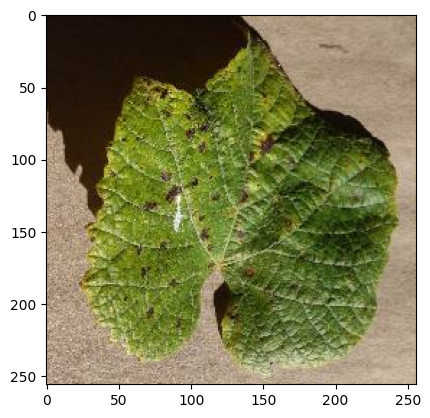

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("Actual label: ", class_names[first_label])
  batch_prediction = model.predict(images_batch)
  print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])


In [45]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 *(np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


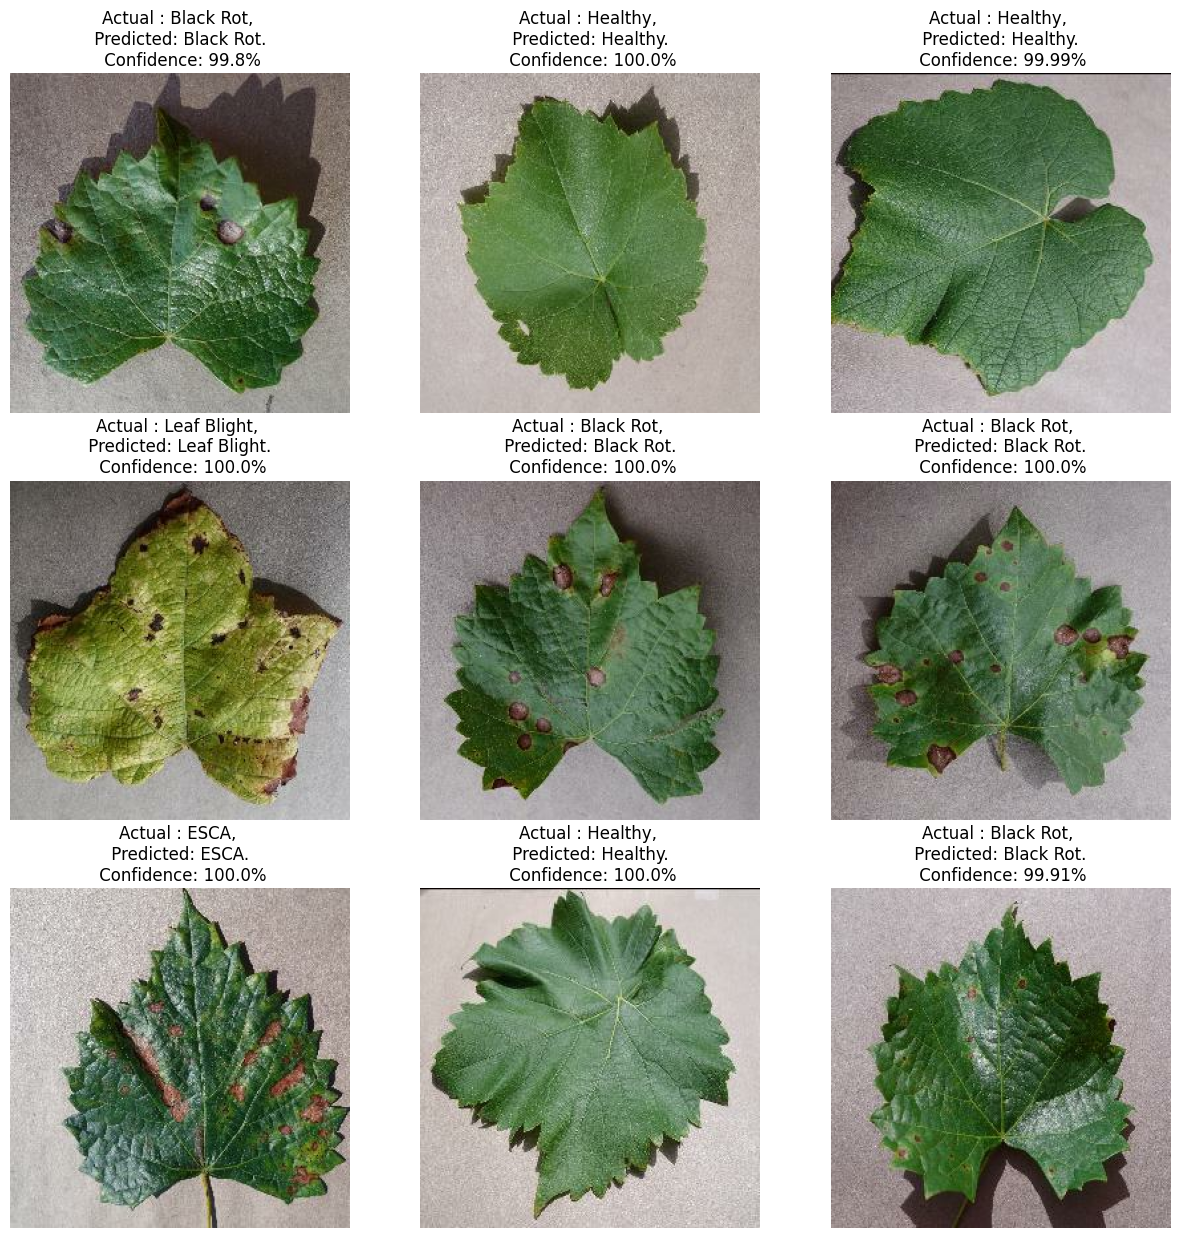

In [48]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual : {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
    plt.axis("off")